# Machine Learning applied to images

## Simple classification example
Tutorial inspired by: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [99]:
%matplotlib inline
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [62]:
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

Digits is a N=1797 dataset of handwritten digits, stored as 8 by 8 gray-scale images


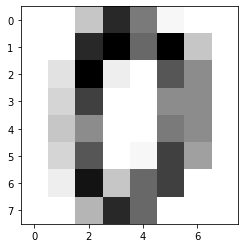

In [63]:
first_image = digits.images[0]
print("Digits is a N={} dataset of handwritten digits, stored as {} by {} gray-scale images".format(
digits.images.shape[0], first_image.shape[0], first_image.shape[1]))
plt.imshow(first_image, cmap='Greys', interpolation='none')

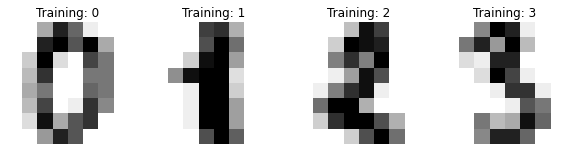

In [95]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

If you first want to try binary classification, you can comment out the following cell to select two targets.

In [65]:
# digit_a = 1
# digit_b = 7

# digits_1 = [image for image, target in zip(data, digits.target) if target==digit_a]
# digits_7 = [image for image, target in zip(data, digits.target) if target==digit_b]

# target_1 = [digit_a]* len(digits_1)
# target_7 = [digit_b]* len(digits_7)

### Split dataset into train and test set

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    digits.target, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True)

### Classify digits and evaluate results

In [93]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

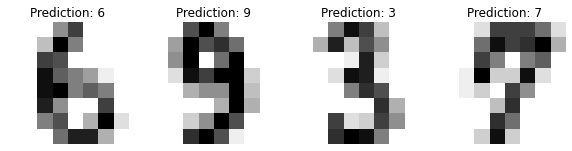

In [96]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, y_pred):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

In [97]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{classification_report(y_test, y_pred)}\n"
)

Classification report for classifier LogisticRegression(random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.97      1.00      0.98        28
           2       0.97      1.00      0.99        33
           3       0.97      0.97      0.97        34
           4       1.00      0.96      0.98        46
           5       0.92      0.94      0.93        47
           6       0.94      0.97      0.96        35
           7       1.00      0.97      0.99        34
           8       0.97      0.97      0.97        30
           9       0.97      0.95      0.96        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360




## More advanced classification example

Download the data from here: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/data.

Tutorial inspired by: https://www.kaggle.com/code/devilsknight/malaria-detection-with-pytorch.

### Background on the dataset
**Microscopic Diagnosis**

Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.

### Data loading and pre-processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from glob import glob
from PIL import Image
from termcolor import colored

import os
print(os.listdir("input/cell_images/cell_images/"))

['Parasitized', 'Uninfected']


Parasitized


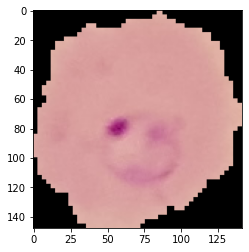

Parasitized


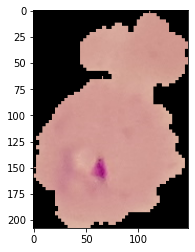

Parasitized


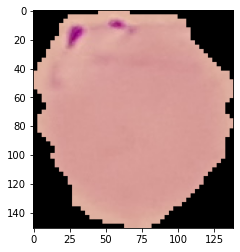

Uninfected


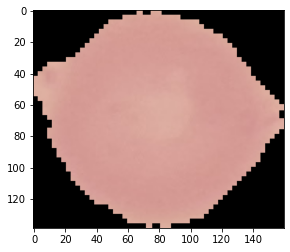

Uninfected


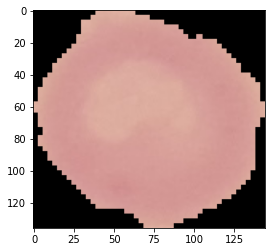

Uninfected


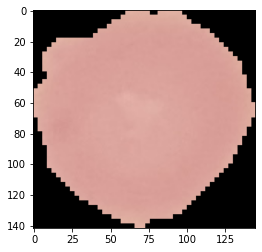

In [13]:
class_names=['Parasitized','Uninfected']
inf = np.array(glob("input/cell_images/cell_images/Parasitized/*"))
uninf = np.array(glob("input/cell_images/cell_images/Uninfected/*"))

for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    print('Parasitized')
    plt.imshow(img)
    plt.show()
    
for i in range(3):
    img_path=uninf[i]
    print('Uninfected')
    img = Image.open(img_path)  
    plt.imshow(img)
    plt.show()

In [5]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [6]:
img_dir='input/cell_images/cell_images/'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

**Exercise** Visualize the data and investigate the distribution of labels.

In [7]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


### Model ResNet50

In [8]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

C:\Users\fiacac\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fiacac\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\fiacac/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 76.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

### Training the model

In [10]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
train(5, model, optimizer, criterion, use_cuda, 'malaria_detection.pt')

### Testing the model

In [13]:
# loading saved model
model.load_state_dict(torch.load('malaria_detection.pt'))

def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

Test Loss: 0.383345


Test Accuracy: 83% (2296/2756)


In [14]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [17]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Correctly predicted
Parasitized


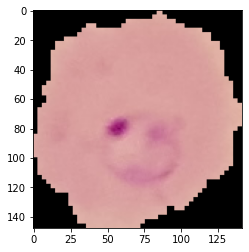

Incorrectly predicted
Uninfected


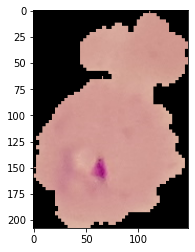

Correctly predicted
Parasitized


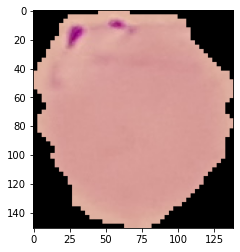

Correctly predicted
Uninfected


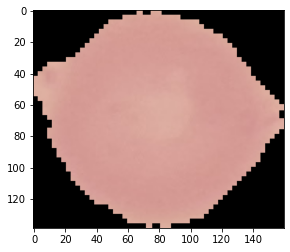

Correctly predicted
Uninfected


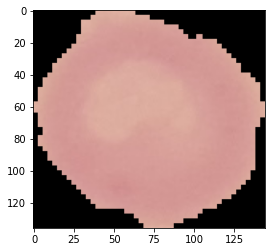

Correctly predicted
Uninfected


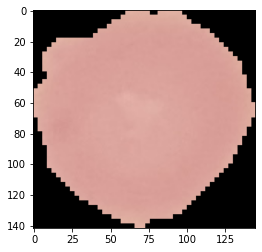

In [20]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob("input/cell_images/cell_images/Parasitized/*"))
uninf = np.array(glob("input/cell_images/cell_images/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print('Correctly predicted')
        print(colored('Parasitized', 'green'))
    else:
        print('Incorrectly predicted')
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print('Correctly predicted')
        print(colored('Uninfected', 'green'))
    else:
        print('Incorrectly predicted')
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

**Exercise** Try to train the model for more epocs and optimize some hyperparameters.

In [ ]:
# Your code here

## Other material about classification and segmentation

Interesting classification examples:
- https://www.kaggle.com/code/vishnu123/malaria-bounding-box
- https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images
- https://www.kaggle.com/code/placidpanda/deep-learning-from-scratch-insights
- https://www.kaggle.com/code/bonhart/brain-mri-data-visualization-unet-fpn